# Surrogate Modeling Batch Example
This example does not use the iterative procedure from the paper. It simply compares the performance of the XGBoost Surrogate Model against the Kriging Model.

## Let's setup our environment

### First let's increase the width of our workspace

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Let's get the imports and functions we need from functions.py

In [2]:
# Imports
from functions import *

In [3]:
%load_ext autoreload
%autoreload 2

### Initialize the parameters and constants

In [4]:
# Set the ABM Evaluation Budget
budget = 1000

# Set the Calibration Threshold
calibration_threshold = 1
_CALIBRATION_THRESHOLD = 1

# Set the ABM parameters and support
islands_exploration_range = np.array([\
        (0,10), # rho
        (0.8,2), # alpha
        (0.0,1.0), # phi
        (0.0,1.0), # pi                                     
        (0.0,1.0), # eps
        (10,100), # N
        (0.0,1.0)]) # Lambda

param_dims = islands_exploration_range.shape[0]

## Evaluate entire Budget in Batch

In [5]:
n_dimensions = islands_exploration_range.shape[0]

final_evaluated_set_X = get_sobol_samples(n_dimensions, budget, islands_exploration_range)
evaluated_set_y = evaluate_islands_on_set(final_evaluated_set_X)

functions.py:258: RuntimeWarning: divide by zero encountered in log
  log_GDP = np.log(GDP)


# Batch comparison
This is a simple comparison to show how Kriging compares to XGBoost on the exact same ABM evalutions

## Kriging Surrogate

In [7]:
tic()
surrogate_models_kriging = kriging(final_evaluated_set_X, evaluated_set_y, random_state=0)
surrogate_models_kriging.train()
print "Time: ", toc()

Time:  14909.4571431


## XGBoost Surrogate

In [18]:
surrogate_model, surrogate_parameter_space = set_surrogate_as_gbt()
tic()
surrogate_model_XGBoost = fit_surrogate_model(final_evaluated_set_X,evaluated_set_y, 
                                              surrogate_model=surrogate_model, 
                                              surrogate_parameter_space=surrogate_parameter_space)

print "Time: ", toc()

Time:  918.104366064


In [19]:
surrogate_model_XGBoost.get_xgb_params()

{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.48707101093536775,
 'max_delta_step': 0,
 'max_depth': 100,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 25,
 'objective': 'reg:linear',
 'reg_alpha': 0.0,
 'reg_lambda': 1.0,
 'scale_pos_weight': 1,
 'seed': 0,
 'silent': 1,
 'subsample': 1.0}

# Out-of-Sample Evaluation
Let's test the performance between the two approaches on 100 random draws from the
space of parameters, conditioned on not being the same parameters from the set used
to train the surrogates above.

In [10]:
# Evaluate on out-of-sample test set
test_size = 100
montecarlos = 100

final_test_size = (test_size*montecarlos)

mse_perf = np.zeros((2,montecarlos))

# Generate unique test set
oos_set = get_sobol_samples(n_dimensions, final_test_size, islands_exploration_range)

selections = []
for i,v in enumerate(oos_set):
    if (v not in final_evaluated_set_X[0]) and (v not in final_evaluated_set_X[1]):
        selections.append(i)
oos_set = oos_set[selections]

while oos_set.shape[0]<final_test_size:
    oos_set = np.vstack([oos_set,get_sobol_samples(n_dimensions, 
                                                   final_test_size, 
                                                   islands_exploration_range)])
oos_set = oos_set[:final_test_size]

y_test = evaluate_islands_on_set(oos_set)

In [20]:
# Evaluate Test Set Performance
y_hat_test = [None,None]

for _KRIGING in [0,1]:
    if _KRIGING:
        tic()
        y_hat_test[_KRIGING] = np.array([surrogate_models_kriging.predict(v) for v in oos_set])
        print "Time: ", toc()
    else:
        tic()
        y_hat_test[_KRIGING] = surrogate_model_XGBoost.predict(oos_set)
        print "Time: ", toc()

    # MSE performance
    for i in range(montecarlos):
        mse_perf[_KRIGING,i] = mean_squared_error(y_test[i:(i+1)*test_size],
                                                  y_hat_test[_KRIGING][i:(i+1)*test_size])

Time:  0.0273079872131


## Plot the densities for each of the methods

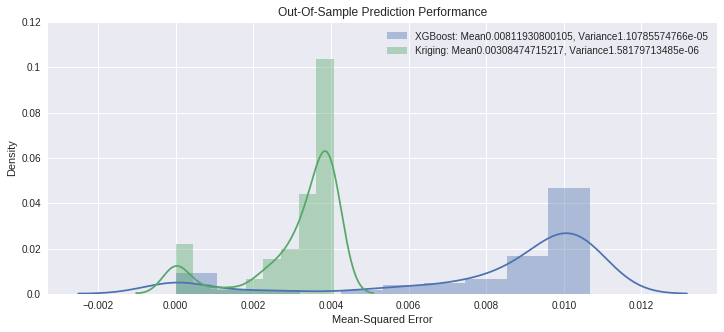

In [22]:
# Plot Performance Results
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

# Plot labels
experiment_labels = ["XGBoost","Kriging"]

fig,ax = plt.subplots(figsize=(12, 5))

xgb_label = "XGBoost: Mean" + str(mse_perf[0].mean()) + ", Variance" + str(mse_perf[0].var())
k_label = "Kriging: Mean" + str(mse_perf[1].mean()) + ", Variance" + str(mse_perf[1].var())

fig1 = sns.distplot(mse_perf[0], label = xgb_label, ax=ax)
fig2 = sns.distplot(mse_perf[1], label = k_label, ax=ax)
plt.title("Out-Of-Sample Prediction Performance")
plt.xlabel('Mean-Squared Error')
plt.yticks(fig1.get_yticks(), fig1.get_yticks() / 10000)
plt.ylabel('Density')
plt.legend()
fig.savefig("xgboost_kriging_ba_comparison_" + str(budget) + ".png");

# $\hat{y}$ vs y

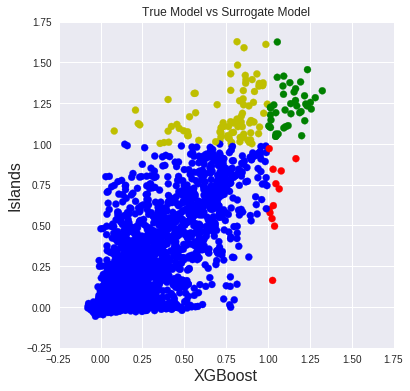

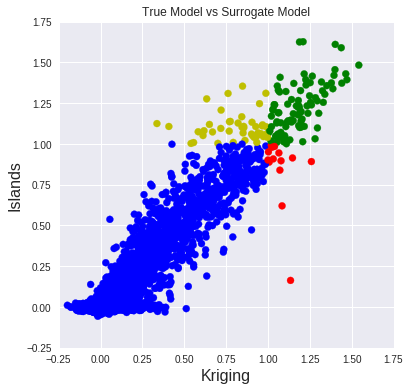

In [21]:
sur_comparison = pd.DataFrame(np.vstack([y_hat_test[0],y_hat_test[1],y_test]).T,columns=['XGBoost','Kriging','Islands'])

for exp in experiment_labels:
    colors = np.array(['b']*sur_comparison.shape[0])
    colors[(sur_comparison['Islands']<_CALIBRATION_THRESHOLD) & (sur_comparison[exp]>=_CALIBRATION_THRESHOLD)]='r'
    colors[(sur_comparison['Islands']>=_CALIBRATION_THRESHOLD) & (sur_comparison[exp]>=_CALIBRATION_THRESHOLD)]='g'
    colors[(sur_comparison['Islands']>=_CALIBRATION_THRESHOLD) & (sur_comparison[exp]<_CALIBRATION_THRESHOLD)]='y'

    fig,ax = plt.subplots(figsize=(6,6))
    
    plt.scatter(x=sur_comparison[exp],y=sur_comparison["Islands"],color=colors);
    
    plt.title("True Model vs Surrogate Model")
    plt.xlabel(exp, fontsize=16)
    plt.ylabel("Islands", fontsize=16)
    plt.xlim(-0.25,1.75)
    plt.ylim(-0.25,1.75)

    fig.savefig(exp + "_model_comparison_" + str(budget) + ".png");

# Time comparison

In [1]:
14909.4571431 / 766.035021067

19.463153423890223

In [2]:
668.94897604 / 0.00867700576782

77094.44870036843